In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from load_data import CSAWS
from utils import *
from config import *
import argparse

/home/phanthc/miniforge3/envs/csaws-segment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
CUSTOM_COLORMAP = [
    (0, 0, 0),  # Background
    (255, 0, 0),  # Nipple
    (0, 0, 255)  # Pectoral muscle
]
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [9]:
def load_test_dataset(test_image_dir, test_mask_dir, transform):
    test_dataset = CSAWS(test_image_dir, test_mask_dir, transform)
    return test_dataset

In [10]:
def load_model(model_file):
    model = torch.load(model_file)
    return model

In [11]:
def plot_figure(id, image, color_mask, color_mask_predict):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(unorm(image).permute(1, 2, 0).cpu(), cmap='gray') 
        plt.title(f'Original Image {id}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(color_mask)
        plt.title(f'True Mask {id}')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(color_mask_predict)
        plt.title(f'Predicted Mask {id}')
        plt.axis('off')
        
        plt.show()

In [21]:
def visualize_predictions(model, test_dataset, device):
    with torch.no_grad():
        model.eval()

        for id in range(len(test_dataset)):
            x, y = test_dataset[id]

            y_predict = F.interpolate(model(x.unsqueeze(0).to(device)), size=y.shape, mode="bilinear").argmax(dim=1).squeeze().cpu().numpy()

            color_mask_predict = np.zeros((*y_predict.shape, 3), dtype=np.uint8)
            color_mask = np.zeros((*y_predict.shape, 3), dtype=np.uint8)

            for i, color in enumerate(CUSTOM_COLORMAP):
                color_mask_predict[y_predict == i] = np.array(color)
                color_mask[y == i] = np.array(color)

            plot_figure(id, x, color_mask, color_mask_predict)

In [22]:
model_file = BEST_MODEL_DIR
test_image_dir = TEST_IMAGE
test_mask_dir = TEST_MASK
transform = TEST_TRANSFORM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_model(model_file)
test_dataset = load_test_dataset(test_image_dir, test_mask_dir, transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


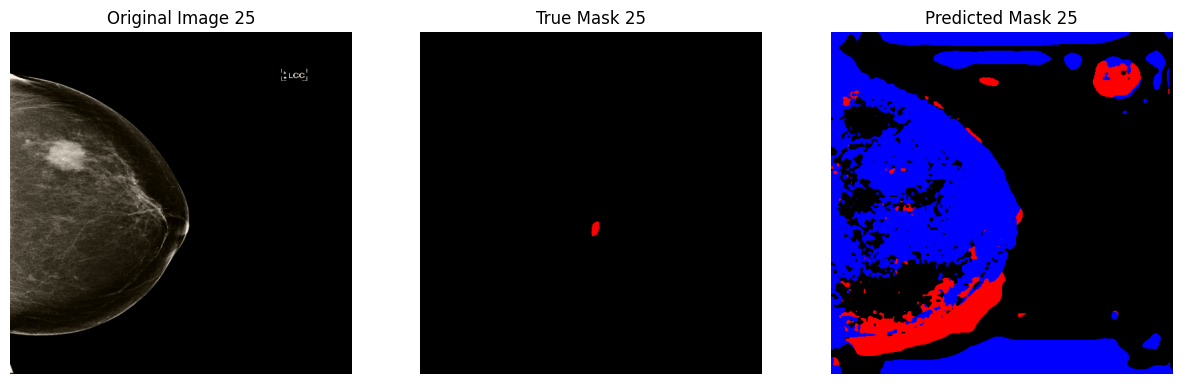

In [20]:
visualize_predictions(model, test_dataset, device)